## Projeto 1 - Métodos de Busca utilizando o jogo Pacman

O problema é composto por um agente (Pacman) e um labirinto. O labirinto é um grid de $n$ linhas e $m$ colunas indexadas de $0$ a $n-1$ e de $0$ a $m-1$ respectivamente, como mostra a Figura 1. Áreas em preto representam paredes, áreas em azul representam posições atravessáveis e as bolinhas brancas representam comidas que devem ser coletadas pelo agente. Ladrilhos em cinza representam fantasmas (posições não atravessáveis que devem ser evitadas pelo agente).

| ![](Figure/Figure1.jpeg) | 
|:--:| 
| Figura 1 - Exemplo de labirinto |


### Labirintos:

Os labirintos utilizados no problema foram criados a partir de adaptações dos labirintos disponíveis em https://github.com/shaunlebron/pacman-mazegen. 


### Objetivo:

O objetivo é fazer o agente (pacman) chegar a um estado final, isto é, chegar a uma posição objetivo (x, y), coletando o maior número possível de comidas durante o caminho. Na Figura 1, os ladrilhos em amarelo e vermelho representam a posição inicial e final do agente, respectivamente. Embora não faça parte do objetivo principal, também é desejável que o agente evite áreas que possuem fantasmas.

##### Ações: 

Existem quatro ações possíveis para o agente: ir para cima, para baixo, para esquerda e para direita. Não é possível ir para uma posição através de diagonais. O agente pode atravessar de um lado do labirinto para o outro lado através de túneis. Um túnel é definido por duas posições atravessáveis de fronteira de mesma linha ou coluna. As posições $(0, 15)$ e $(27, 15)$ representam um túnel na Figura 1.

**O custo de cada ação é definido por:** 
- $1$,  se o estado resultante pela ação for uma comida.
- $1000$, caso contrário.

**Desse modo o agente possui como objetivo encontrar um caminho até a posição objetivo com custo mínimo.**


### Modelagem do problema:

Um estado é representado por uma dupla $(i, j)$ que indica a posição do pacman, i.e, $i$ indica a linha e $j$ a coluna do labirinto. A armazenagem do labirinto foi feita por meio uma lista de objetos de uma classe Posição. A classe Posição possui as coordenadas $i, j$ do estado e um boolean que é verdadeiro caso a posição seja uma comida ou falso, caso contrário. Apenas as posições atravessáveis e as posições dos fantasmas são armazenadas, ou seja, não são armazenadas as posições que são paredes.

As ações são representadas por duplas - $(0, 1);(0, -1);(1, 0);(-1,0)$ que são somadas ao estado atual e geram o estado resultante a ação correspondente.

### Heurísticas utilizadas:

#### Distância Manhattan
Dado dois pontos, $p_1$ em $(x_1, y_1)$ e $p_2$ em $(x_2, y_2)$ a distância Manhattan (ou Norma $L1$) é calculada como:
$$D_{manh} = |x_1 - x_2| + |y_1 - y_2|$$

**Admissibilidade**: dada as ações definidas prlo problema, o agente só realiza movimentos paralelos aos eixos $x$ e $y$. Dessa forma o custo total do caminho entre dois pontos sempre será maior ou igual à distância Manhattan entre esses pontos. Note que isso não seria verdadeiro se o Pacman andasse em diagonais. Temos então que a distância Manhattan é uma heurística admissível.

**Monotonicidade**: seja $A$ um nó tal que $h(A) = x$. Para os quatro possíveis nós vizinhos de $A$, dado o cálculo da distância Manhattan, o $h(n)$ desses vizinhos pode ser $x - 1$ ou $x + 1$. Se o custo para ir do nó A ao seus vizinhos for maior que um, temos que a heurística é monotônica.

#### Distância Wavefront
A distância Wavefront é a distância de um campo potencial a partir de uma posição. A construção desse campo é baseado em uma BFS, ou seja, para um nó $A$, cujo $h(A) = x$, e cujo nó pai tem $h(A_{pai}) = x - 1$, os vizinhos do nó $A$ possuem $h(A_{filho}) = x + 1$ (note que é preciso ter uma lista de nós visitados, pois o nó filho não pode retornar para o estado do nó pai) .
Esse algoritmo também é conhecido com expansão térmica.

| ![](Figure/Figure2.png) | 
|:--:| 
| Figura 2 - Exemplo de Labirinto criado usando a distância Wavefront |

Na Figura 2 podemos ver um exemplo de um labirinto criado utilizando a distância Wavefront. Quanto mais distante do objetivo, mais claro (frio) é o valor.

Para construí-lo, começamos com um nó $n$ (referente a posição objetivo) cujo $h(n) = 0$. Para cada um de seus nós filhos $a_i$ temos que $h(a_i) = h(n) + 1$. Adicionamos esses nós filhos em uma pilha e seguimos iterativamente até esgotarmos a pilha. Dessa forma, o valor do campo de cada nó nada mais é que a sua profundidade em relação à raiz (posição objetivo).

**Admissibilidade:**: dada as ações definidas pelo problema, o agente só realiza movimentos paralelos aos eixos $x$ e $y$. Dessa forma o custo total do caminho entre dois pontos sempre será maior ou igual à distância Wavefront, pois por definição, a distância wavefront sempre será o menor valor a ser percorrido de um nó até sua raíz.

**Monotonicidade:** seja $A$ um nó tal que $h(A) = x$. Para os quatro possíveis nós vizinhos de $A$, dado o cálculo da distância Wavefront, o $h(n)$ desses vizinhos pode ser $x - 1$ ou $x + 1$. Se o custo para ir do nó A ao seus vizinhos for maior que 1, temos que a heurística é monotônica.

#### Evasão de Fantasmas
Para esta heurística, a proximidade do agente em relação aos fantasmas é considerada. O intuito é evitar áreas do labirinto que contém tais adversários ,pois em um cenário real do jogo, o contato dos fantasmas com o agente causa o término da partida sem que a meta seja alcançada. Para esta heurística, é utilizada a distância Euclidiana. Dado dois pontos $p_1 = (x_1, y_1)$ e $p_2 = (x_2, y_2)$, temos:
$$D_{eucl}(p_2,p_1) = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$$
Considerando a presença de $n$ fantasmas no labirinto, o cálculo do indicador de proximidade de um fantasma $i, 0 \leq i < n$, em relação ao agente é:
$$
 G_{avoidance}(p_{pacman}, p_{ghost\ i}) = 
  \begin{cases} 
   \dfrac{C}{D_{eucl}(p_{pacman}, P_{ghost\ i})} & \text{if } D_{eucl}(p_{pacman}, P_{ghost\ i}) < R \\
   0       & \text{otherwise }
  \end{cases}
$$
Sendo $C$ o parâmetro de custo de aproximação do fantasma, e $R$ o parâmetro de faixa de aproximação do fantasma. Logo, enquanto o fantasma está mais distante que o valor $R$ de um fantasma, o custo de aproximação do respectivo elemento é $0$. Quando o agente entra nesta faixa de aproximação, o custo é proporcional à distância do fantasma em relação ao custo $C$. Quanto mais próximo do fantasma, maior é a influência do custo.
A heurística é calculada por:
$$h_{ghost avoidance}(p_{pacman}) = D_{eucl}(p_{pacman}, p_{goal}) + \sum_{i = 0}^{n}G_{avoidance}(p_{pacman}, p_{ghost\ i})$$
Em outras palavras, leva em consideração a proximidade do pacman a posição objetivo e em relação a todos os fantasmas.

**Admissibilidade:** dada as ações definidas pelo problema, o agente só realiza movimentos paralelos aos eixos $x$ e $y$. Dessa forma o custo total do caminho entre dois pontos sempre será maior ou igual à distância Euclidiana entre esses pontos. Temos então, que a distância Euclidiana é uma heurística admissível.

**Monotonicidade:** seja $A$ um nó tal que $h(A) = x$. Para os quantro possíveis nós vizinhos de $A$, o $h(n)$ desses nós até a meta pode ser $x - m + G$ ou $x + m + G$, com $0 < m \leq 1$ sendo a contribuição da distância até a meta, e $G \geq 0$ a contribuição da proximidade dos fantasmas. Se o custo para ir do nó $A$ ao seus vizinhos for maior que 1, temos que a heurística é monotônica.


### Implementação:

Todos os métodos de busca utilizados foram adaptações dos métodos da biblioteca AIMA disponível em https://github.com/aimacode/aima-python.


### Buscas implementadas:

Todas as buscas implementadas (exceto das buscas locais) armazenam os nós que foram visitados, isto é, só passam por cada nó uma vez.

- Sem informação:
    - BFS: o nó raiz é expandido primeiro, seguido dos sucessores deste nó, seguido dos sucessores dos sucessores do nó raiz, e assim sucessivamente. É uma busca completa porém não é ótima, pois os caminhos não tem o mesmo custo. Todos os nós permanecem na memória.
    
    - DFS: sempre expande o nó mais pronfundo na árvore de busca, implementado utilizando uma pilha. Não é completa se uma ramificação não tem fim. Porém como nesse problema é feita a verificação dos nós visitados, a DFS é completa. Assim como a BFS, a BFS não é ótima. Uma vez que uma ramificação é explorada completamente, pode ser removida da memória.

- Informadas:
	- Busca Gulosa: esta busca tenta seguir pelo nó mais próximo da meta, assumindo que isso levará para a solução mais rápida. A função objetivo leva em consideração apenas a heurística aplicada. O método não é ótimo, mas é completo, pois mantém controle dos estados repetidos. 
	- A*: avalia não apenas o custo para chegar até o objetivo do nó (heurística), mas também o custo para chegar até o nó analisado. Se a heurística for admissível e monotônica, o método é completo e ótimo. 

- Locais:
	- Hill Climbing: este método utiliza apenas informação do estado atual, e se move para os vizinhos imediatos desse estado. A função objetivo leva em consideração apenas uma função que deve ser maximizada (ou minimizada, como no caso desse problema). Utilizamos a própria função heurística como a função a ser minimizada. A meta é encontrar o melhor estado (no nosso caso, o mínimo possível para a heurística). Como considera apenas a informação do nó atual, finalizará a execução ao encontrar um mínimo local, sem necessariamente chegar ao objetivo. Não é completo, nem ótimo. Utiliza pouca memória, por não armazenar os nós explorados.
	- Simulated annealing: Esse método é semelhante ao Hill Climbing, porém ao invés de sempre selecionar um melhor estado, o simulated annealing permite que ocasionalmente estados piores sejam escolhidos, de forma a evitar mínimos locais. Quanto mais iterações passam, menos chances existem de ser selecionado um estado pior. Assim, no início da execução o algoritmo permite uma melhor exploração dos estados para buscar o mínimo global.
    

### Testes realizados:

Para a realização dos testes, foram utilizados labirintos de quatro tamanhos  e configurações diferentes:

- Tiny Maze: 30 x 28, 3 fantasmas
- Small Maze: 30 x 84, 9 fantasmas
- Medium Maze: 60 x 112, 24 fantasmas
- Big Maze: 90 x 140, 45 fantasmas

Para cada busca implementada e para cada um dos labirintos foram realizadas três execuções variando posição inicial do agente, posição objetivo e posição dos fantantas. 

#### Métricas coletadas:

Para cada execução, foram coletadas os seguintes dados:

- Tempo de execução.
- Número máximo de nós mantidos na memória ao mesmo tempo (tamanho da maior fila/pilha/lista durante execução).
- Número de nós expandidos.
- Número de nós do tipo comida expandidos.
- Número de nós no caminho.
- Número de nós no caminho expandido.

Além disso, foram criados gráficos referentes ao caminho encontrado por cada uma das buscas em cada uma das execuções.

### Resultados:

Os dados e os resultados de todos os testes realizados estão disponíveis em uma planilha que pode ser acessada por meio deste link https://docs.google.com/spreadsheets/d/1nf5nsZ5R_v15ccnkRu17dY-VKT9dF8f_NV3H7ozTv2o/edit?usp=sharing. As imagens geradas pelos experimentos podem ser encontradas em https://drive.google.com/drive/folders/1L8zYwPyFqCntiLe1HxMP9sexop3WzoRE?usp=sharing. Nesse relatório, para melhor visualização, apresentaremos os resultados baseados na média entre cada execução de mesmo tamanho de labirinto. 
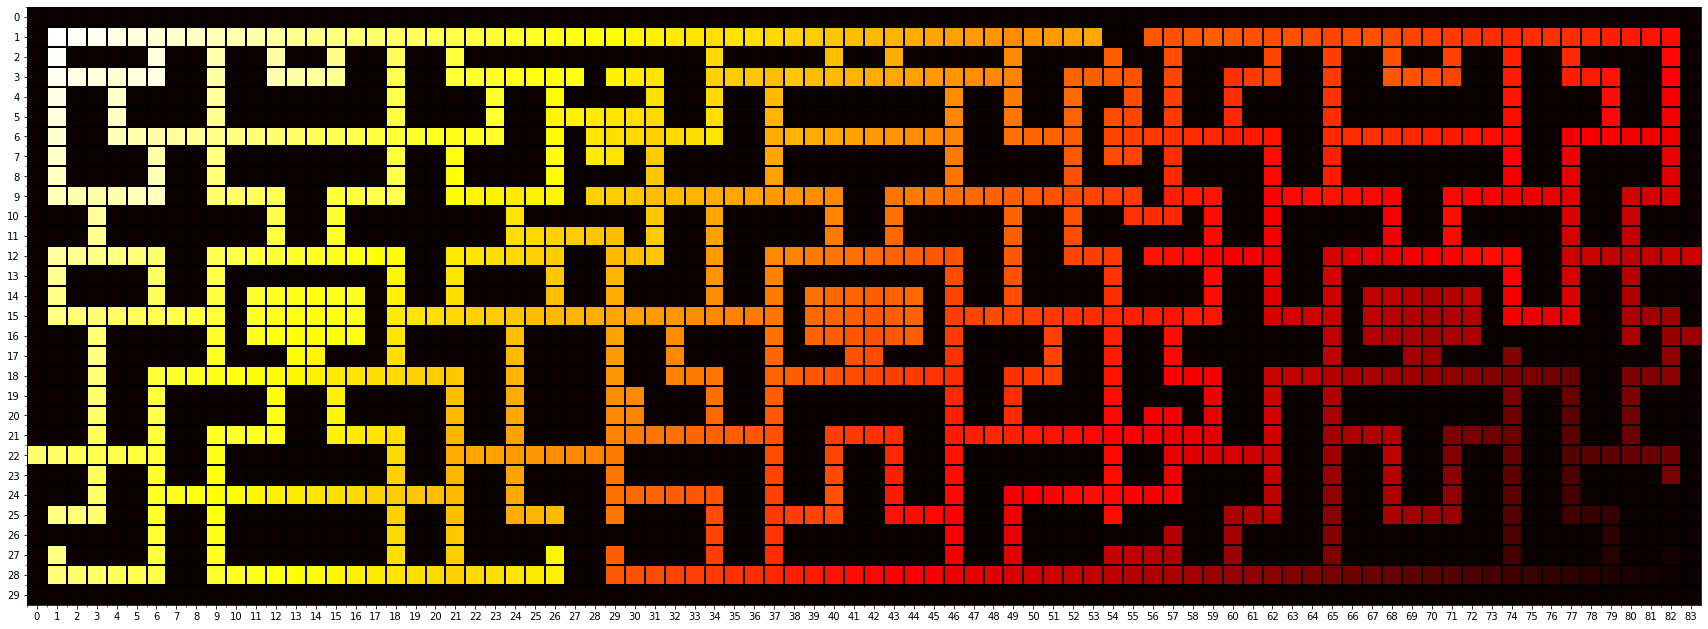
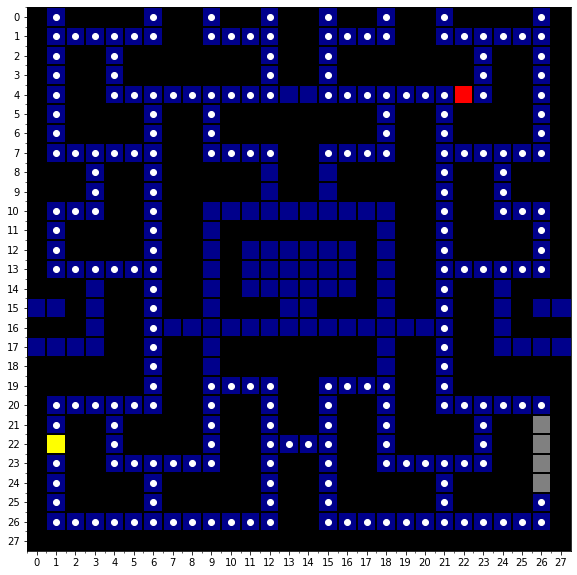

In [15]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# importa o arquivo e guarda em um dataframe do Pandas
df = pd.read_csv( 'results.csv', sep=',', index_col=None) 
n_alg = 12 #numero de algoritmos
n = 3 * n_alg #numero de testes

#insere coluna para identificar o tamanho do labirinto
df.insert(0,'Maze',"")
df['Maze'] = (df.index/(n)).astype('int32')
df["Maze"].replace({0: "Tiny", 1: "Small", 2:"Medium", 3:"Big"}, inplace=True)

#calcula o custo do caminho
df['Custo Caminho'] = 1000*(df['Número de nós no caminho'] - df['Número de nós comida no caminho']) + df['Número de nós comida no caminho']

#### Buscas que não encontraram solução: 

Muitas das execuções de algoritmos da busca local não encontraram uma solução, como será explicado posteriormente. Nas tabelas seguintes, consideraremos apenas as execuções nas quais o algoritmo encontrou uma solução.

In [16]:
df.loc[df['Goal'] == 0].iloc[:, 0:2] #execuções que não encontraram solução

,Maze,Busca
8,Tiny,Hill-Climbing - Manhattan
9,Tiny,Hill-Climbing - Ghost Avoidance Euclidean
20,Tiny,Hill-Climbing - Manhattan
21,Tiny,Hill-Climbing - Ghost Avoidance Euclidean
33,Tiny,Hill-Climbing - Ghost Avoidance Euclidean
44,Small,Hill-Climbing - Manhattan
45,Small,Hill-Climbing - Ghost Avoidance Euclidean
47,Small,Simulated Annealing - Wavefront
56,Small,Hill-Climbing - Manhattan
57,Small,Hill-Climbing - Ghost Avoidance Euclidean


In [17]:
df.drop(df[df.Goal == 0].index, inplace=True)
del df['Goal']

tiny = df.loc[df['Maze'] == "Tiny"]
small = df.loc[df['Maze'] == "Small"]
medium = df.loc[df['Maze'] == "Medium"]
big = df.loc[df['Maze'] == "Big"]

#### Abaixo apresentaremos a média entre as execuções de cada algoritmos, separadas por tamanho de maze e ordenadas pelo custo do caminho.

### Tiny Maze

In [18]:
tiny = tiny.groupby("Busca").mean().round(2)
tiny.sort_values(by=['Custo Caminho']).iloc[:, 1:]

,Máximo de nós simultâneos na memória,Número de nós expandidos,Número de nós comida expandidos,Número de nós no caminho,Número de nós comida no caminho,Custo Caminho
Busca,,,,,,
A* Search - Manhattan,23.33,109.67,107.33,46.33,45.67,712.33
A* Search - Wavefront Heuristic,22.00,104.33,101.67,46.33,45.67,712.33
A* Search - Ghost Avoidance Euclidean,20.67,116.67,112.67,49.67,49.00,715.67
BFS,18.33,281.33,203.67,37.00,33.00,4033.00
Hill-Climbing - Wavefront,1.67,24.33,19.33,25.00,19.67,5353.00
Greedy Search - Wavefront Heuristic,15.33,36.00,28.67,37.00,29.33,7696.00
Hill-Climbing - Manhattan,2.00,40.00,28.00,41.00,29.00,12029.00
Greedy Search - Manhattan,17.00,59.67,42.33,53.00,38.33,14705.00
Greedy Search - Ghost Avoidance Euclidean,20.00,156.33,118.33,57.00,40.67,16374.00


## Small Maze

In [19]:
small = small.groupby("Busca").mean().round(2)
small.sort_values(by=['Custo Caminho']).iloc[:, 1:]

,Máximo de nós simultâneos na memória,Número de nós expandidos,Número de nós comida expandidos,Número de nós no caminho,Número de nós comida no caminho,Custo Caminho
Busca,,,,,,
A* Search - Manhattan,48.00,537.67,505.00,110.67,109.67,1109.67
A* Search - Wavefront Heuristic,46.33,508.67,478.00,110.67,109.67,1109.67
A* Search - Ghost Avoidance Euclidean,61.67,673.67,640.67,146.00,145.00,1145.00
Greedy Search - Manhattan,31.33,129.33,98.33,106.67,83.67,23083.67
BFS,22.33,958.00,722.33,94.67,65.67,29065.67
Greedy Search - Wavefront Heuristic,34.67,93.67,62.00,94.67,63.00,31729.67
Hill-Climbing - Wavefront,2.00,93.67,61.33,94.67,62.33,32395.67
Greedy Search - Ghost Avoidance Euclidean,41.00,513.33,377.33,149.33,102.33,47102.33
DFS,104.33,711.33,532.00,308.67,227.67,81227.67


## Medium Maze

In [20]:
medium = medium.groupby("Busca").mean().round(2)
medium.sort_values(by=['Custo Caminho']).iloc[:, 1:]

,Máximo de nós simultâneos na memória,Número de nós expandidos,Número de nós comida expandidos,Número de nós no caminho,Número de nós comida no caminho,Custo Caminho
Busca,,,,,,
A* Search - Manhattan,134.67,2194.33,1825.67,155.33,149.00,6482.33
A* Search - Wavefront Heuristic,144.00,2260.33,1895.00,155.33,149.00,6482.33
A* Search - Ghost Avoidance Euclidean,152.67,2396.67,1986.67,213.33,207.00,6540.33
Hill-Climbing - Wavefront,2.00,95.00,76.00,96.00,76.67,19410.00
Greedy Search - Manhattan,50.33,163.00,115.67,118.67,92.67,26092.67
Greedy Search - Wavefront Heuristic,45.33,68.33,40.67,69.33,41.33,28041.33
BFS,47.33,1531.33,1151.33,69.33,41.00,28374.33
Greedy Search - Ghost Avoidance Euclidean,73.33,1220.67,893.00,95.33,52.33,43052.33
Simulated Annealing - Wavefront,1.00,1487.00,1368.67,555.33,461.00,94794.33


## Big Maze

In [21]:
big = big.groupby("Busca").mean().round(2)
big.sort_values(by=['Custo Caminho']).iloc[:, 1:]

,Máximo de nós simultâneos na memória,Número de nós expandidos,Número de nós comida expandidos,Número de nós no caminho,Número de nós comida no caminho,Custo Caminho
Busca,,,,,,
A* Search - Manhattan,256.67,3828.33,3226.33,203.00,199.00,4199.00
A* Search - Wavefront Heuristic,268.33,3800.67,3212.33,203.00,199.00,4199.00
A* Search - Ghost Avoidance Euclidean,246.67,3696.33,3001.67,265.00,261.00,4261.00
BFS,73.67,3961.00,3058.67,153.00,112.00,41112.00
Hill-Climbing - Wavefront,2.00,152.00,108.33,153.00,109.33,43776.00
Greedy Search - Wavefront Heuristic,71.67,152.00,104.67,153.00,105.67,47439.00
Greedy Search - Manhattan,95.00,1089.00,815.00,265.67,172.67,93172.67
Greedy Search - Ghost Avoidance Euclidean,180.00,3645.33,2774.00,400.33,300.33,100300.33
DFS,614.33,3008.67,2324.33,1097.67,849.67,248849.67


In [22]:
#método para gerar gráficos
def make_plot(feature):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(big.index, big[feature], label="Big", marker='P')
    ax.scatter(medium.index, medium[feature], label="Medium", marker='X')
    ax.scatter(small.index, small[feature], label="Small", marker='D')
    ax.scatter(tiny.index, tiny[feature], label="Tiny", marker='o')
    ax.legend()
    plt.ylabel(feature)
    plt.xticks(rotation=80)
    plt.show()

## Análise

Os gráficos abaixo representam o número de nós e o custo do caminho encontrado pelos algoritmos em cada tamanho de labirinto, respectivamente:

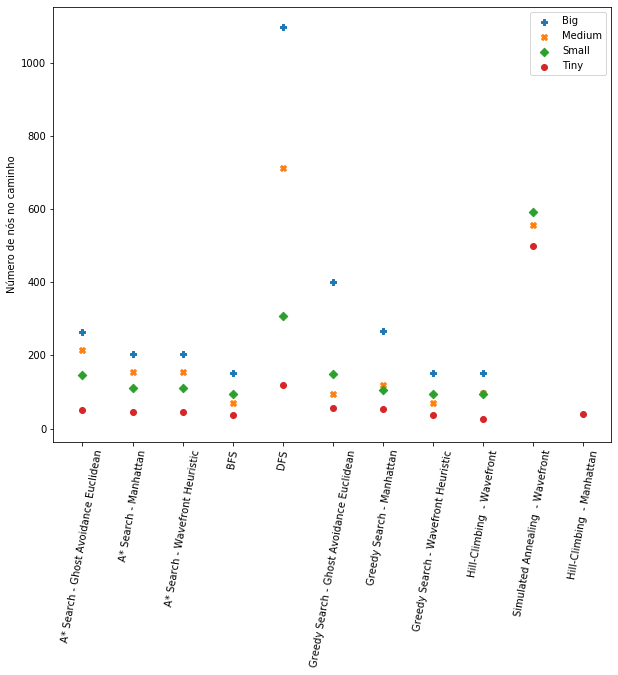

In [23]:
make_plot('Número de nós no caminho')

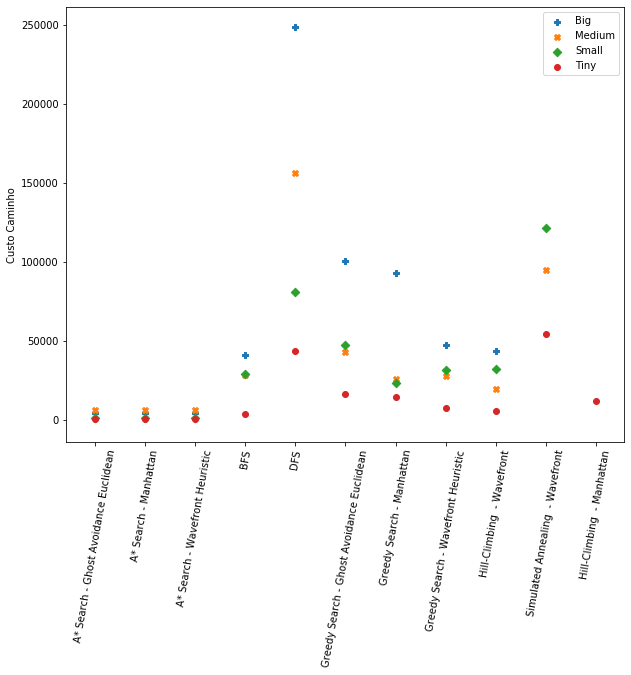

In [24]:
make_plot("Custo Caminho")

Podemos ver pelos gráficos e tabelas que para todos os tamanhos de maze, a BFS sempre calcula um caminho mínimo, porém não ótimo se considerarmos o custo das ações, como era o esperado. Alguns outros algoritmos como o Greedy Search e Hill Climbing também encontram o menor caminho com as heurísticas Manhattan e Wavefront, porém não ótimo. Já o A* encontra o caminho ótimo como era esperado.

Para a heurística da distância Manhattan podemos ver que os algoritmos apresentam o mesmo comportamento que a heurística Wavefront, porém com o nosso Maze isso poderia não ser verdade, pois a existência de túneis faz com que heurísticas de distâncias (Manhattan e Euclidiana) deixem de ser admissíveis. Ao passar por um túnel, o valor do $h(n)$ pode reduzir drasticamente caso o fim do túnel leve a um lugar perto do objetivo, porém o custo para atravessar pode ser 1 se houver comida do outro lado do túnel. Caso o custo para atravessar o túnel fosse maior mesmo com a comida ou caso removêssemos os túneis, as heurísticas de distância voltariam a ser admissíveis e teríamos soluções ótimas com o A*.

O comportamento das buscas gulosa e A* foi o esperado para a heurística de Evasão de Fantasmas: encontram um caminho válido para a meta, evitando as regiões as quais contém fantasmas, sempre que possível. É uma linha relevante para melhorias, visando a execução do método em um ambiente real do jogo, o qual os fantasmas também se movem.

Para a busca local através do algoritmo Hill-Climbing, é possível ver com clareza a sua principal debilidade: utilizando-se das heurísticas de Distância Manhattan e Evasão de Fantasmas, quase todos os casos, com exceção de um, ficam presos em mínimos locais e não encontraram uma solução. A situação é muito pior para a heurística de Evasão de Fantasmas, pois, como não tem informação a respeito das zonas de fantasmas, é altamente penalizado ao chegar até elas, impossibilitando a continuidade da rota. Logo, tais heurísticas se mostraram inadequadas para se resolver a busca com este algoritmo. 

A execução considerando a heurística Wavefront teve maior taxa de sucesso, pois devido a distribuição de custos ser diretamente proporcional à distância da meta, a possibilidade de existir mínimos locais é menor (depende fortemente do formato do labirinto). Para este caso do Wavefront, é possível ver as vantagens da busca local: baixo uso de memória, no máximo dois nós em memória simultaneamente. Consequentemente, isso também se traduz no rápido tempo de execução do algoritmo, na casa de dezenas de milissegundos. Por conseguinte, a utilidade do método está muito atrelada à característica da heurística utilizada, e pode ser complexo modelar o problema a fim de que não existam mínimos locais. 

Os gráficos abaixo representam o número de nós simultâneos na memória, o tempo de execução médio e o número de nós expandidos durante a execução dos algoritmos para cada tamanho de maze.

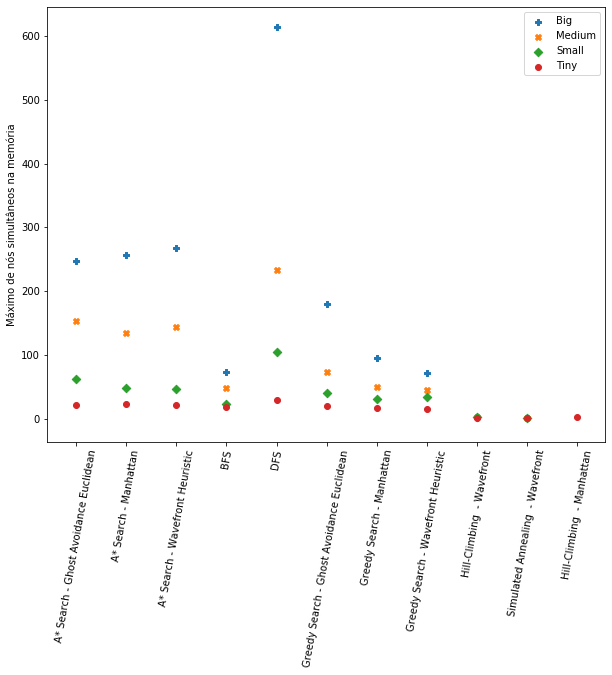

In [25]:
make_plot('Máximo de nós simultâneos na memória')

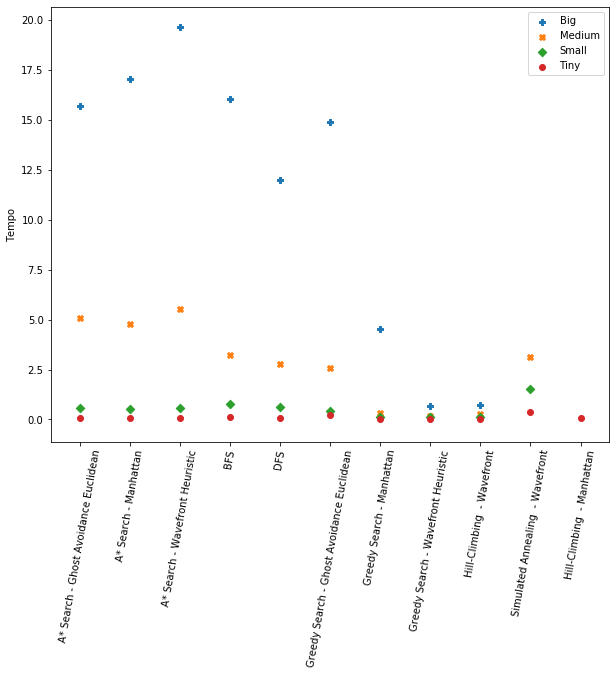

In [26]:
make_plot('Tempo')

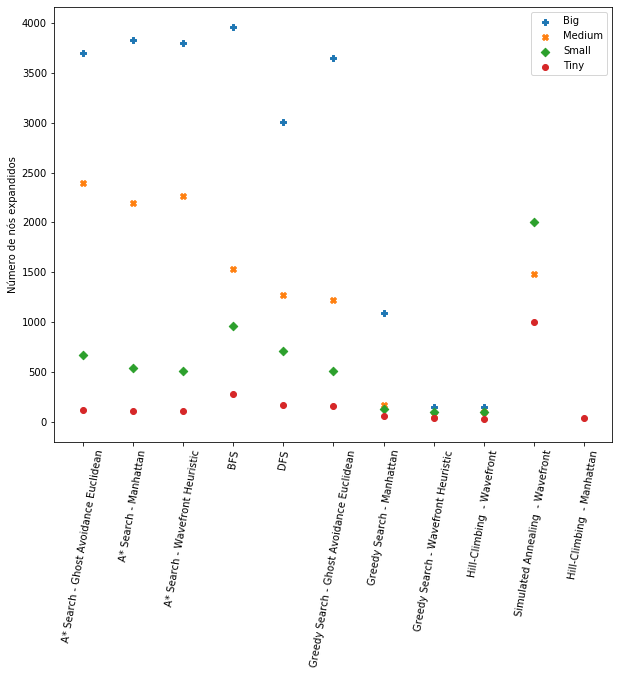

In [27]:
make_plot('Número de nós expandidos')

## Conclusão

Em relação a otimicidade da solução, a busca A* apresentou ou melhores resultados, como esperado, encontrando uma solução ótima. Porém, no que diz respeito ao tempo, uso de memória e número de nós expandido, a busca A* representa desempenho baixo e similar aos das buscas não informadas. 

Ainda, é válido observar que o desempenho em relação a otimicidade da solução foi superior em todos os algoritmos que utilizaram a heurística wavefront. Entretanto, é importante ressaltar que tal heurística demanda um pré processamento de mesmo custo de uma BFS para o cálculo dos valores da distância de cada posição.